## Motion Correction -NoRMCorre
This notebook uses the `CaImAn` package to perform motion correction of Calcium imaging. Specifically, the notebook compares the performance of normal rigid frame-based motion correction with that of piecewise motion correction using `NoRMCorre` algorithm.

More information about the NoRMCorre algorithm can be found in the following paper:

Pnevmatikakis, E.A., and Giovannucci A. (2017). NoRMCorre: An online algorithm for piecewise rigid motion correction of calcium imaging data. Journal of Neuroscience Methods, 291:83-92 [[paper]](https://doi.org/10.1016/j.jneumeth.2017.07.031)

First, download the `CaImAn` package,  and create a `caiman` conda environment, following the instruction from the [[link]](https://github.com/flatironinstitute/CaImAn/). 
Before starting the notebook, the following commands need to be executed from the terminal:
```bash
   source activate caiman
   conda install notebook ipykernel
   ipython kernel install --user
   pip install caiman
   ```

In [1]:
# Check the environment for the notebook
import sys
if sys.prefix[-6:]== "caiman":
    print("You are in the caiman environment")
else:
    print("You are not in the caiman environment")

You are in the caiman environment


In [2]:
# import image processing tools
import cv2
import caiman as cm
from caiman.motion_correction import MotionCorrect, tile_and_correct, motion_correction_piecewise
from caiman.utils.utils import download_demo

# import analyzing, plotting, multiprocessing tools
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from ipyparallel import Client

/Users/Sylvia/miniconda3/envs/caiman/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Specify the target imaging movie in the data folder, load it and view it.

In [3]:
# load the original imaging data (stored in the data folder)
# file_name needs to be a list
file_name = 'WT_G6virus.tif'
file_name = [os.path.join('../data',file_name)]
data_orig = cm.load_movie_chain(file_name)

100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


In [4]:
# specify parameters for viewing
downsample_ratio = .2 # downsample in time
offset_orig = np.min(data_orig[:1000]) # compute an offset value

# play movie (press q to exit)
data_orig.resize(1, 1, downsample_ratio).play(
    gain=2, offset=-offset_orig)

reshaping along z


Start a cluster to run motion correction in parallel.

In [5]:
if 'dview' in locals():
    dview.terminate()
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='ipyparallel', n_processes=None, single_thread=False)

Stopping cluster...
NOT SLURM
Waiting for cluster to stop....... done
Starting cluster...Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
......Using 4 processes


Create a motion correction object.

In [16]:
# Set up parameters
niter_rig = 1          # number of iterations for rigid motion correction
max_shifts = (20, 20)  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
splits_rig =  56       # for parallelization split the movies in  num_splits chuncks across time
                     
strides =  (96, 96)    # create a new patch every x pixels for pw-rigid correction
overlaps = (48, 48)    # overlap between pathes (size of patch strides+overlaps)
splits_els =  56       # for parallelization split the movies in  num_splits chuncks across time

upsample_factor_grid = 4  # upsample factor to avoid smearing when merging patches
max_deviation_rigid = 6   # maximum deviation allowed for patch with respect to rigid shifts

# create a motion correction object
G6Image = MotionCorrect(file_name[0], offset_orig,
                   dview = dview, max_shifts = max_shifts, niter_rig = niter_rig,
                   splits_rig = splits_rig,
                   strides = strides, overlaps= overlaps, splits_els = splits_els,
                   upsample_factor_grid = upsample_factor_grid,
                   max_deviation_rigid = max_deviation_rigid, 
                   shifts_opencv = True, nonneg_movie = True)

### Rigid Motion Correction
Simple rigid motion correction algorithm by averaging all frames into the template, match all frames to the template and and optimize template to align with the frames.

In [17]:
# correct for rigid motion correction and save the file (in memory mapped form)
G6Image.motion_correct_rigid(save_movie=True)

Rigid Motion Correction
64893


/Users/Sylvia/PDSB/CaImAn/caiman/base/movies.py:266: UserWarning: Casting the array to float 32
  warnings.warn('Casting the array to float 32')
/Users/Sylvia/PDSB/CaImAn/caiman/base/movies.py:349: UserWarning: Casting the array to float 32
  warnings.warn('Casting the array to float 32')


cubic interpolation
cubic interpolation
cubic interpolation
Adding to movie 64893
0
saving!
** Startting parallel motion correction **
** Finished parallel motion correction **
nan


/Users/Sylvia/miniconda3/envs/caiman/lib/python3.5/site-packages/numpy/linalg/linalg.py:2257: RuntimeWarning: invalid value encountered in sqrt
  ret = sqrt(sqnorm)


In [18]:
# load the motion corrected movie
# View the movie and compare with the original one
data_rig = cm.load(G6Image.fname_tot_rig)
bord_px_rig = np.ceil(np.max(G6Image.shifts_rig)).astype(np.int)
offset_rig = np.min(data_rig[:1000])
cm.concatenate([data_orig.resize(0.6, 0.6, downsample_ratio)-offset_orig,
                data_rig.resize(0.6, 0.6, downsample_ratio)-offset_rig], axis=2).play(
                gain=1.5, offset=0, bord_px = bord_px_rig) 

  0%|          | 0/1 [00:00<?, ?it/s]

loading in memory


100%|██████████| 1/1 [00:05<00:00,  5.08s/it]

mmap


reshaping along x and y
(307, 307)
reshaping along z
reshaping along x and y
(307, 307)
reshaping along z


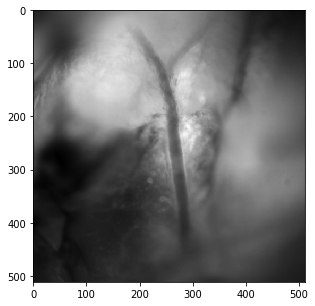

In [19]:
# Plot the updated template
plt.figure(figsize = (5,5))
plt.imshow(G6Image.total_template_rig, cmap = 'gray')

Text(0,0.5,'pixels')

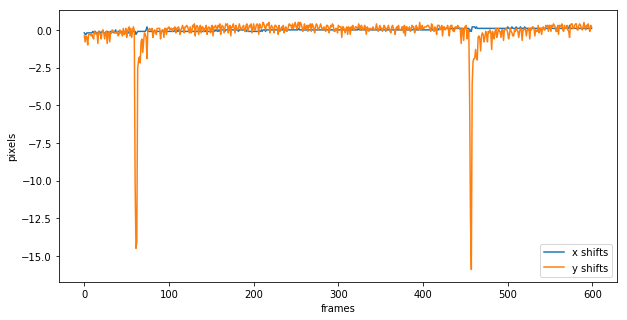

In [32]:
# Plot the pixel shifts in x or y direction for each frame
plt.figure(figsize = (10,5))
plt.plot(G6Image.shifts_rig)
plt.legend(['x shifts','y shifts'])
plt.xlabel('frames')
plt.ylabel('pixels')

### Piecewise Motion Correction -NoRMCorre
Remaining non-rigid motion is corrected using NoRMCorre algorithm for piecewise rigid registration. The field of view is divided into overlapping patches, and each patch is assigned a displacement vector. Thereby non-rigid motion can be approximated in a piecewise-rigid manner.

In [21]:
G6Image.motion_correct_pwrigid(save_movie=True, template=G6Image.total_template_rig)

Adding to movie 64893
0
saving mmap of ../data/WT_G6virus.tif
**** MOVIE NOT SAVED BECAUSE num_splits is not None ****
** Startting parallel motion correction **
** Finished parallel motion correction **
Adding to movie 64893
0
saving mmap of ../data/WT_G6virus.tif
** Startting parallel motion correction **
** Finished parallel motion correction **


In [48]:
# load the motion corrected movie
# View the movie and compare with the original one and the rigid corrected one
data_norm = cm.load(G6Image.fname_tot_els)
offset_norm = np.nanmin(data_norm[:1000]) 
bord_px_norm = np.ceil(np.maximum(np.max(np.abs(G6Image.x_shifts_els)),
                                 np.max(np.abs(G6Image.y_shifts_els)))).astype(np.int)
cm.concatenate([data_orig.resize(0.6, 0.6, downsample_ratio)-offset_orig,
                data_rig.resize(0.6, 0.6, downsample_ratio)-offset_rig,
                data_norm.resize(0.6, 0.6, downsample_ratio)-offset_norm], axis=2).play(
                gain=1.5, offset=0, bord_px = bord_px_norm) 

  0%|          | 0/1 [00:00<?, ?it/s]

loading in memory


100%|██████████| 1/1 [00:06<00:00,  6.46s/it]

mmap


reshaping along x and y
(307, 307)
reshaping along z
reshaping along x and y
(307, 307)
reshaping along z
reshaping along x and y
(307, 307)
reshaping along z


Text(0.5,0,'frames')

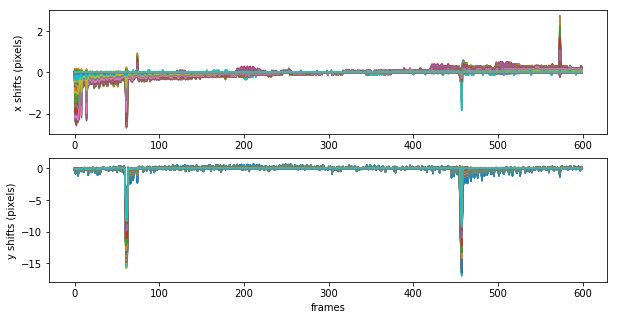

In [36]:
plt.figure(figsize = (10,5))
plt.subplot(2, 1, 1)
plt.plot(G6Image.x_shifts_els)
plt.ylabel('x shifts (pixels)')
plt.subplot(2, 1, 2)
plt.plot(G6Image.y_shifts_els)
plt.ylabel('y shifts (pixels)')
plt.xlabel('frames')

### Comparison & Analysis
Quantify the correlation of each frame with the mean template for original, rigid and pw-rigid images.

In [51]:
final_size = np.subtract(G6Image.total_template_els.shape, 2 * bord_px_norm) # remove pixels in the boundaries
winsize = 100
swap_dim = False
resize_fact_flow = .2

tmpl_rig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    file_name[0], final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
    G6Image.fname_tot_rig[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_els, correlations_els, flows_els, norms_els, crispness_els = cm.motion_correction.compute_metrics_motion_correction(
    G6Image.fname_tot_els[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

[18, -18, 18, -18]
Local correlations..
(600, 476, 476)
Compute Smoothness.. 
Compute correlations.. 
0
100
200
300
400
500
Compute optical flow .. 
reshaping along z
0


/Users/Sylvia/miniconda3/envs/caiman/lib/python3.5/site-packages/numpy/linalg/linalg.py:2257: RuntimeWarning: invalid value encountered in sqrt
  ret = sqrt(sqnorm)


100
mmap
[18, -18, 18, -18]
Local correlations..
(600, 476, 476)
Compute Smoothness.. 
Compute correlations.. 
0
100
200
300
400
500
Compute optical flow .. 
reshaping along z
0
100
mmap
[18, -18, 18, -18]
Local correlations..
(600, 476, 476)
Compute Smoothness.. 
Compute correlations.. 
0
100
200
300
400
500
Compute optical flow .. 
reshaping along z
0
100


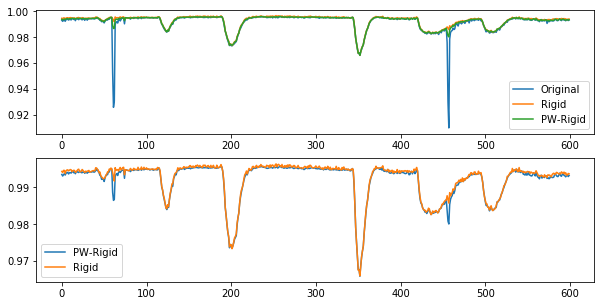

In [67]:
# Plot of Correlation
plt.figure(figsize = (10,5))
plt.subplot(211); plt.plot(correlations_orig); plt.plot(correlations_rig); plt.plot(correlations_els)
plt.legend(['Original','Rigid','PW-Rigid'])
plt.subplot(212); plt.plot(correlations_els); plt.plot(correlations_rig)
plt.legend(['PW-Rigid', 'Rigid'])

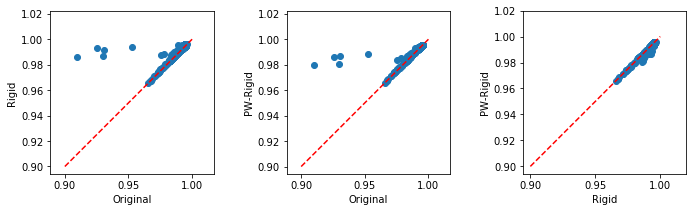

In [80]:
# Scatter plot
plt.figure(figsize = (12,3))
plt.subplot(131); plt.scatter(correlations_orig, correlations_rig); plt.xlabel('Original'); 
plt.ylabel('Rigid'); plt.plot([0.9,1.0],[0.9,1.0],'r--')
axes = plt.gca(); axes.set_xlim([0.9,1.0]); axes.set_ylim([0.9,1.0]); plt.axis('square');

plt.subplot(132); plt.scatter(correlations_orig, correlations_els); plt.xlabel('Original'); 
plt.ylabel('PW-Rigid'); plt.plot([0.9,1.0],[0.9,1.0],'r--')
axes = plt.gca(); axes.set_xlim([0.9,1.0]); axes.set_ylim([0.9,1.0]); plt.axis('square');

plt.subplot(133); plt.scatter(correlations_rig, correlations_els); plt.xlabel('Rigid'); 
plt.ylabel('PW-Rigid'); plt.plot([0.9,1.0],[0.9,1.0],'r--')
axes = plt.gca(); axes.set_xlim([0.9,1.0]); axes.set_ylim([0.9,1.0]); plt.axis('square');